Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p tensorflow

Sebastian Raschka 

CPython 3.6.1
IPython 6.0.0

tensorflow 1.2.0


# Model Zoo -- (Classic) Perceptron

Implementation of the classic Perceptron by Frank Rosenblatt for binary classification (here: 0/1 class labels).

In [2]:
##########################
### DATASET
##########################

import numpy as np

data = np.genfromtxt('../data/perceptron_toydata.txt', delimiter='\t')
X, y = data[:, :2], data[:, 2]
y = y.astype(np.int)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


##########################
### SETTINGS
##########################

# Architecture
n_features = X.shape[1]


##########################
### GRAPH DEFINITION
##########################

g = tf.Graph()
with g.as_default():
   
    # Graph Inputs
    features = tf.placeholder(dtype=tf.float32, 
                              shape=[None, n_features], name='features')
    targets = tf.placeholder(dtype=tf.float32, 
                             shape=[None, 1], name='targets')

    # Model Parameters
    weights = tf.Variable(tf.zeros(shape=[n_features, 1], 
                          dtype=tf.float32), name='weights')
    bias = tf.Variable([[0.]], dtype=tf.float32, name='bias')
    

    
    # Forward Pass
    linear = tf.add(tf.matmul(features, weights), bias, name='linear')
    ones = tf.ones(shape=tf.shape(linear)) 
    zeros = tf.zeros(shape=tf.shape(linear))
    prediction = tf.where(condition=tf.less(linear, 0.),
                          x=zeros, 
                          y=ones, 
                          name='prediction')
    
    # Backward Pass
    errors = targets - prediction
    weight_update = tf.assign_add(weights, 
                                  tf.reshape(errors * features, (n_features, 1)),
                                  name='weight_update')
    bias_update = tf.assign_add(bias, errors,
                                name='bias_update')
    
    train = tf.group(weight_update, bias_update, name='train')
    
    saver = tf.train.Saver(name='saver')

    
    
##########################
### TRAINING & EVALUATION
##########################

with tf.Session(graph=g) as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(5):
        for example, target in zip(X_train, y_train):
            feed_dict = {'features:0': example.reshape(-1, n_features),
                         'targets:0': target.reshape(-1, 1)}
            _ = sess.run(['train'], feed_dict=feed_dict)


    w, b = sess.run(['weights:0', 'bias:0'])    
    print('Model parameters:\n')
    print('Weights:\n', w)
    print('Bias:', b)

    saver.save(sess, save_path='perceptron')
    
    pred = sess.run('prediction:0', feed_dict={features: X_train})
    errors = np.sum(pred.reshape(-1) != y_train)
    print('\nNumber of training errors:', errors)


Model parameters:

Weights:
 [[ 2.02931881]
 [ 0.5932976 ]]
Bias: [[-1.]]

Number of training errors: 0


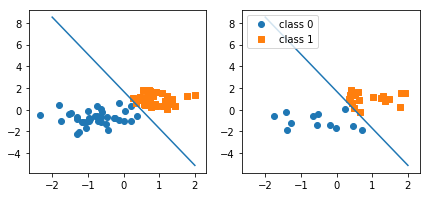

In [5]:
##########################
### 2D Decision Boundary
##########################

x_min = -2
y_min = ( -(w[0] * x_min) / w[1]
          -(b[0] / w[1]) )

x_max = 2
y_max = ( -(w[0] * x_max) / w[1]
          -(b[0] / w[1]) )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()